In [2]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers

In [3]:
def read_file(filename):
    file = open(filename, mode='rt', encoding='utf-8')
    text = file.read()
    file.close()        
    return text

In [4]:
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      for sent in sents:
          sent.pop(2)
      return sents

In [5]:
data=read_file("deu.txt")

In [6]:
hin=to_lines(data)

In [7]:
hin

[['Go.', 'Geh.'],
 ['Hi.', 'Hallo!'],
 ['Hi.', 'Grüß Gott!'],
 ['Run!', 'Lauf!'],
 ['Run.', 'Lauf!'],
 ['Wow!', 'Potzdonner!'],
 ['Wow!', 'Donnerwetter!'],
 ['Duck!', 'Kopf runter!'],
 ['Fire!', 'Feuer!'],
 ['Help!', 'Hilfe!'],
 ['Help!', 'Zu Hülf!'],
 ['Hide.', 'Versteck dich!'],
 ['Hide.', 'Versteckt euch!'],
 ['Stay.', 'Bleib!'],
 ['Stop!', 'Stopp!'],
 ['Stop!', 'Anhalten!'],
 ['Wait!', 'Warte!'],
 ['Wait.', 'Warte.'],
 ['Begin.', 'Fang an.'],
 ['Do it.', 'Mache es!'],
 ['Do it.', 'Tue es.'],
 ['Go on.', 'Mach weiter.'],
 ['Hello!', 'Hallo!'],
 ['Hello!', 'Sers!'],
 ['Hello.', 'Hallo!'],
 ['Hurry!', 'Beeil dich!'],
 ['Hurry!', 'Schnell!'],
 ['I hid.', 'Ich versteckte mich.'],
 ['I hid.', 'Ich habe mich versteckt.'],
 ['I ran.', 'Ich rannte.'],
 ['I see.', 'Ich verstehe.'],
 ['I see.', 'Aha.'],
 ['I try.', 'Ich versuche es.'],
 ['I try.', 'Ich probiere es.'],
 ['I won!', 'Ich hab gewonnen!'],
 ['I won!', 'Ich habe gewonnen!'],
 ['I won.', 'Ich habe gewonnen.'],
 ['Oh no!', 'Oh, Nein!

In [8]:
def clean_english_sentence(sentence):
    # Remove punctuation using regex
    sentence = re.sub(r'[^\w\s]', '', sentence)
    return sentence.lower()

In [8]:
chars_to_remove = string.punctuation + '।' 

In [10]:
hin= [[clean_english_sentence(pair[0]), clean_english_sentence(pair[1])] for pair in hin]

In [11]:
hin

[['go', 'geh'],
 ['hi', 'hallo'],
 ['hi', 'grüß gott'],
 ['run', 'lauf'],
 ['run', 'lauf'],
 ['wow', 'potzdonner'],
 ['wow', 'donnerwetter'],
 ['duck', 'kopf runter'],
 ['fire', 'feuer'],
 ['help', 'hilfe'],
 ['help', 'zu hülf'],
 ['hide', 'versteck dich'],
 ['hide', 'versteckt euch'],
 ['stay', 'bleib'],
 ['stop', 'stopp'],
 ['stop', 'anhalten'],
 ['wait', 'warte'],
 ['wait', 'warte'],
 ['begin', 'fang an'],
 ['do it', 'mache es'],
 ['do it', 'tue es'],
 ['go on', 'mach weiter'],
 ['hello', 'hallo'],
 ['hello', 'sers'],
 ['hello', 'hallo'],
 ['hurry', 'beeil dich'],
 ['hurry', 'schnell'],
 ['i hid', 'ich versteckte mich'],
 ['i hid', 'ich habe mich versteckt'],
 ['i ran', 'ich rannte'],
 ['i see', 'ich verstehe'],
 ['i see', 'aha'],
 ['i try', 'ich versuche es'],
 ['i try', 'ich probiere es'],
 ['i won', 'ich hab gewonnen'],
 ['i won', 'ich habe gewonnen'],
 ['i won', 'ich habe gewonnen'],
 ['oh no', 'oh nein'],
 ['relax', 'entspann dich'],
 ['shoot', 'feuer'],
 ['shoot', 'schieß'],
 

### Text To Sequences 

##### Step1:Convert list to a dataframe

In [12]:
df = pd.DataFrame(hin, columns=['English', 'Hindi'])


In [13]:
df.head()

,English,Hindi
0,go,geh
1,hi,hallo
2,hi,grüß gott
3,run,lauf
4,run,lauf


##### Step2:Capture the length of each sentence

In [14]:
hin


[['go', 'geh'],
 ['hi', 'hallo'],
 ['hi', 'grüß gott'],
 ['run', 'lauf'],
 ['run', 'lauf'],
 ['wow', 'potzdonner'],
 ['wow', 'donnerwetter'],
 ['duck', 'kopf runter'],
 ['fire', 'feuer'],
 ['help', 'hilfe'],
 ['help', 'zu hülf'],
 ['hide', 'versteck dich'],
 ['hide', 'versteckt euch'],
 ['stay', 'bleib'],
 ['stop', 'stopp'],
 ['stop', 'anhalten'],
 ['wait', 'warte'],
 ['wait', 'warte'],
 ['begin', 'fang an'],
 ['do it', 'mache es'],
 ['do it', 'tue es'],
 ['go on', 'mach weiter'],
 ['hello', 'hallo'],
 ['hello', 'sers'],
 ['hello', 'hallo'],
 ['hurry', 'beeil dich'],
 ['hurry', 'schnell'],
 ['i hid', 'ich versteckte mich'],
 ['i hid', 'ich habe mich versteckt'],
 ['i ran', 'ich rannte'],
 ['i see', 'ich verstehe'],
 ['i see', 'aha'],
 ['i try', 'ich versuche es'],
 ['i try', 'ich probiere es'],
 ['i won', 'ich hab gewonnen'],
 ['i won', 'ich habe gewonnen'],
 ['i won', 'ich habe gewonnen'],
 ['oh no', 'oh nein'],
 ['relax', 'entspann dich'],
 ['shoot', 'feuer'],
 ['shoot', 'schieß'],
 

In [15]:
eng_l=[]
hin_l=[]
for pair in hin:
    eng_l.append(len(pair[0].split()))
for pair in hin:
    hin_l.append(len(pair[1].split()))

In [16]:
length_df = pd.DataFrame({'eng':eng_l, 'hin':hin_l})

In [17]:
length_df.head()

,eng,hin
0,1,1
1,1,1
2,1,2
3,1,1
4,1,1


In [18]:
len=length_df["eng"].max()
length_df[length_df["eng"]==len]

,eng,hin
277890,101,76


In [19]:
length_df["hin"].max()

76

##### Step3:Tokenize the strings

In [20]:
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [21]:
text=["My anme is tganpooj", "i likes cats"]
tokenization(text).word_index

{'my': 1, 'anme': 2, 'is': 3, 'tganpooj': 4, 'i': 5, 'likes': 6, 'cats': 7}

In [22]:
eng=df.loc[:,"English"]

In [23]:
eng_tokenizer=tokenization(eng)
count = 0
for key in eng_tokenizer.word_index:
    count += 1

In [24]:
eng_vocab_length=count+1


In [25]:
hin=df.loc[:,"Hindi"]
hin_tokenizer=tokenization(hin)
count_hin = 0
for key in hin_tokenizer.word_index:
    count_hin += 1

In [26]:
hindi_vocab_length=count_hin+1

In [27]:
hindi_vocab_length

39393

In [28]:
eng_vocab_length

18104

##### Step4:Convert to sequences

In [29]:
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

### Build the model

In [30]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.25, random_state = 12)

In [31]:
trainX = encode_sequences(hin_tokenizer,10,train.loc[:,"Hindi"])
trainY = encode_sequences(eng_tokenizer,10,train.loc[:,"English"])

In [32]:
testX = encode_sequences(hin_tokenizer,10,test.loc[:,"Hindi"])
testY = encode_sequences(eng_tokenizer,10,test.loc[:,"English"])

In [33]:
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [34]:
hindi_vocab_length

39393

In [35]:
eng_vocab_length

18104

In [36]:
import tensorflow as tf
model = build_model(hindi_vocab_length, eng_vocab_length,10,10, 512)
adam = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy')


C:\Users\tanta\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          )

Epoch 1/30
326/326 [==============================] - 1814s 6s/step - loss: 4.3954 - val_loss: 4.0256
Epoch 2/30
326/326 [==============================] - 1817s 6s/step - loss: 3.9449 - val_loss: 3.9371
Epoch 3/30
326/326 [==============================] - 1707s 5s/step - loss: 3.8825 - val_loss: 3.9020
Epoch 4/30
326/326 [==============================] - 1309s 4s/step - loss: 3.8083 - val_loss: 3.8009
Epoch 5/30
326/326 [==============================] - 1514s 5s/step - loss: 3.6715 - val_loss: 3.6619
Epoch 6/30
 17/326 [>.............................] - ETA: 22:53 - loss: 3.5732

In [110]:
preds = model.predict(testX.reshape((testX.shape[0],testX.shape[1])))
type(preds)

numpy.ndarray

In [122]:
import numpy as np
def get_word(index, tokenizer):
    # Convert NumPy array to scalar if it's a single-element array
    if isinstance(index, np.ndarray):
        if index.size == 1:
            index = index.item()  # Convert single-element array to scalar
        else:
            return None  # If index is not a single element, return None
    
    # Ensure index is an integer
    if not isinstance(index, int):
        return None
    
    # Map index to word
    return tokenizer.index_word.get(index, None)


In [124]:

# Ensure len is not shadowed
len = __builtins__.len

# Your loop and rest of the code
preds_text = []
for i in preds:
    temp = []
    print("i:", i)  # Debugging: print the value of i
    for j in range(len(i)):
        print("i[j]:", i[j])  # Debugging: print the value of i[j]
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t is None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if t is None:
                temp.append('')
            else:
                temp.append(t)
    preds_text.append(' '.join(temp))


i: [[1.3340954e-03 4.8907902e-02 1.4622453e-01 ... 2.1698629e-06
  1.6266625e-06 1.5715415e-06]
 [4.2521693e-03 2.9986009e-02 1.2721246e-02 ... 3.2196394e-06
  3.2042012e-06 2.7236501e-06]
 [1.5640283e-02 3.4475196e-02 5.8262483e-03 ... 1.7826499e-06
  1.9533295e-06 1.7244535e-06]
 ...
 [9.8249912e-01 4.2112009e-04 9.3182507e-06 ... 2.8680600e-10
  2.4582028e-10 2.4947289e-10]
 [9.8301190e-01 4.0947853e-04 9.0197927e-06 ... 2.7214472e-10
  2.3269248e-10 2.3617303e-10]
 [9.8310375e-01 4.0748320e-04 8.9684145e-06 ... 2.6955396e-10
  2.3035247e-10 2.3378818e-10]]
i[j]: [1.3340954e-03 4.8907902e-02 1.4622453e-01 ... 2.1698629e-06 1.6266625e-06
 1.5715415e-06]
i[j]: [4.2521693e-03 2.9986009e-02 1.2721246e-02 ... 3.2196394e-06 3.2042012e-06
 2.7236501e-06]
i[j]: [1.5640283e-02 3.4475196e-02 5.8262483e-03 ... 1.7826499e-06 1.9533295e-06
 1.7244535e-06]
i[j]: [1.1582132e-01 2.6634304e-02 1.9002513e-03 ... 7.4951168e-07 8.2065986e-07
 7.7385710e-07]
i[j]: [6.9577730e-01 7.2101452e-03 2.5734553e

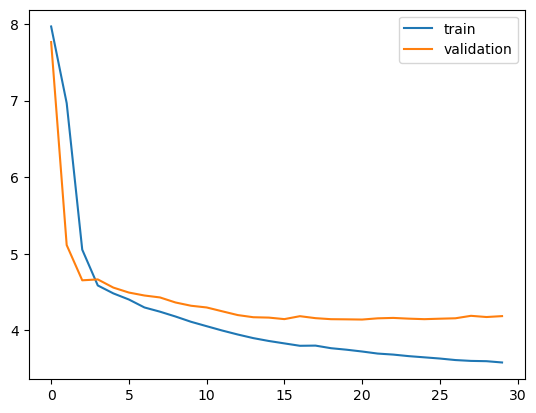

In [128]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()